# Diagnosis of a bad Digits classification - bias and variance

Make a Naive Bayes classifier for the Digits task, this uses an 8x8 greyscale of the digits 0-9, the task is to predict the correct label from the image.

This Notebook is a part of my [Data Science Delivered](https://github.com/ianozsvald/data_science_delivered) notes. License: CC-By-Attribution.

Here we want to understand the bias/variance tradeoff. For each classifier we fit using progressively larger amounts of training data and score using a set-aside test set. We never vary the test set (and we don't use that data for training). The same test set is shared across all the classifiers, the same subsets of training data are used for each classifier (both using `RANDOM_STATE`).

Source:
* http://cs229.stanford.edu/materials/ML-advice.pdf

Classifiers:
* DummyClassifier
* BernoulliNaiveBayes
* LogisticRegression
* DecisionTree (using defaults)
* RandomForest (with defaults and a better set of hyperparamters)


In [2]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.dummy import DummyClassifier
from sklearn import tree
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

from sklearn import naive_bayes

# let's plot inline
%matplotlib inline

# load the digits dataset
from sklearn.datasets import load_digits
digits = load_digits()

In [3]:
# install watermark using
# %install_ext https://raw.githubusercontent.com/rasbt/watermark/master/watermark.py
%load_ext watermark
# show a watermark for this environment
%watermark -d -m -v -p numpy,matplotlib,sklearn,seaborn,pandas -g

2017-10-04 

CPython 3.6.2
IPython 6.1.0

numpy 1.13.1
matplotlib 2.0.2
sklearn 0.18.2
seaborn 0.8.0
pandas 0.20.3

compiler   : GCC 4.8.2 20140120 (Red Hat 4.8.2-15)
system     : Linux
release    : 4.9.45-040945-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit
Git hash   : 322359a1d2032562ecc693433647bd6332f23e84


In [4]:
# start a separate QTconsole for interactive coding
#%qtconsole

In [5]:
# flatten and binarise the 2D input image - this is our basic feature set
# we could improve the features here by adding new columns to X
arr_digits_greyscale = [digit.flatten() for digit in digits.images]
arr_digits = [digit.flatten()>=8 for digit in digits.images]
X_greyscale = np.vstack(arr_digits_greyscale)
X = np.vstack(arr_digits)
y = digits.target
print("X has shape {}, y has shape {}".format(X.shape, y.shape))

X has shape (1797, 64), y has shape (1797,)


# Split the original data into a validation set (for scoring) and a training set

In [6]:
# We'll fix a random seed so the results are the same on each run,
# you wouldn't do this in practice but it does help when you're debugging
RANDOM_STATE = 43

test_size = 0.1 # validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=RANDOM_STATE)

In [7]:
# now take n% from X_train, train on this, then test on all of y_train
train_set_sizes = np.arange(0.01, 1.0, 0.01)

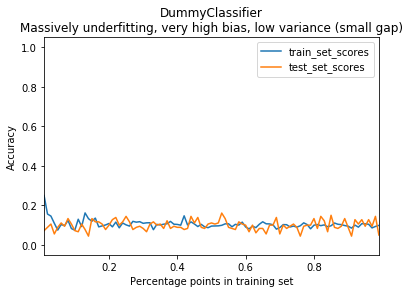

In [9]:
training_set_scores = np.zeros_like(train_set_sizes)
test_set_scores = np.zeros_like(train_set_sizes)

clf = DummyClassifier()

for training_set_idx, train_set_size in enumerate(train_set_sizes):
    X_train_subset, _, y_train_subset, _ = train_test_split(X_train, y_train, test_size=1-train_set_size, random_state=RANDOM_STATE)

    clf.fit(X_train_subset, y_train_subset)
    train_score = clf.score(X_train_subset, y_train_subset)
    training_set_scores[training_set_idx] = train_score
    
    test_score = clf.score(X_test, y_test)
    test_set_scores[training_set_idx] = test_score

df_scores = pd.DataFrame({'idx': train_set_sizes, 'test_set_scores': test_set_scores, 'train_set_scores': training_set_scores})
df_scores = df_scores.set_index('idx')
df_scores = df_scores[['train_set_scores', 'test_set_scores']] # reorder columns

df_scores.plot()
plt.ylim((-0.05, 1.05))
plt.ylabel("Accuracy")
plt.xlabel("Percentage points in training set")
plt.title("DummyClassifier\nMassively underfitting, very high bias, low variance (small gap)");

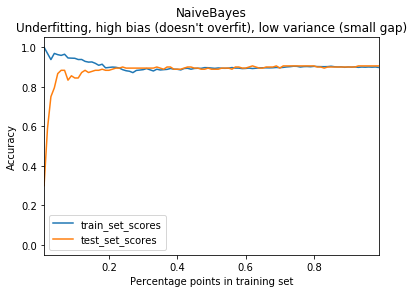

In [12]:
training_set_scores = np.zeros_like(train_set_sizes)
test_set_scores = np.zeros_like(train_set_sizes)

clf = naive_bayes.BernoulliNB()

for training_set_idx, train_set_size in enumerate(train_set_sizes):
    X_train_subset, _, y_train_subset, _ = train_test_split(X_train, y_train, test_size=1-train_set_size, random_state=RANDOM_STATE)

    clf.fit(X_train_subset, y_train_subset)
    train_score = clf.score(X_train_subset, y_train_subset)
    training_set_scores[training_set_idx] = train_score
    
    test_score = clf.score(X_test, y_test)
    test_set_scores[training_set_idx] = test_score

df_scores = pd.DataFrame({'idx': train_set_sizes, 'test_set_scores': test_set_scores, 'train_set_scores': training_set_scores})
df_scores = df_scores.set_index('idx')
df_scores = df_scores[['train_set_scores', 'test_set_scores']] # reorder columns

df_scores.plot()
plt.ylim((-0.05, 1.05))
plt.ylabel("Accuracy")
plt.xlabel("Percentage points in training set")
plt.title("NaiveBayes\nUnderfitting, high bias (doesn't overfit), low variance (small gap)");

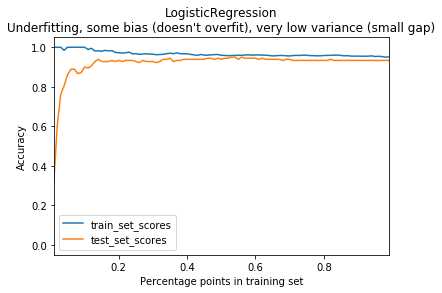

In [13]:
training_set_scores = np.zeros_like(train_set_sizes)
test_set_scores = np.zeros_like(train_set_sizes)

clf = linear_model.LogisticRegression()

for training_set_idx, train_set_size in enumerate(train_set_sizes):
    X_train_subset, _, y_train_subset, _ = train_test_split(X_train, y_train, test_size=1-train_set_size, random_state=RANDOM_STATE)

    clf.fit(X_train_subset, y_train_subset)
    train_score = clf.score(X_train_subset, y_train_subset)
    training_set_scores[training_set_idx] = train_score
    
    test_score = clf.score(X_test, y_test)
    test_set_scores[training_set_idx] = test_score

df_scores = pd.DataFrame({'idx': train_set_sizes, 'test_set_scores': test_set_scores, 'train_set_scores': training_set_scores})
df_scores = df_scores.set_index('idx')
df_scores = df_scores[['train_set_scores', 'test_set_scores']] # reorder columns

df_scores.plot()
plt.ylim((-0.05, 1.05))
plt.ylabel("Accuracy")
plt.xlabel("Percentage points in training set")
plt.title("LogisticRegression\nUnderfitting, some bias (doesn't overfit), very low variance (small gap)");

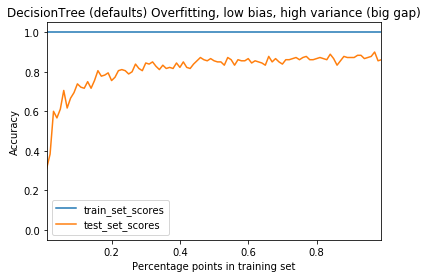

In [15]:
training_set_scores = np.zeros_like(train_set_sizes)
test_set_scores = np.zeros_like(train_set_sizes)

clf = tree.DecisionTreeClassifier()

for training_set_idx, train_set_size in enumerate(train_set_sizes):
    X_train_subset, _, y_train_subset, _ = train_test_split(X_train, y_train, test_size=1-train_set_size, random_state=RANDOM_STATE)

    clf.fit(X_train_subset, y_train_subset)
    train_score = clf.score(X_train_subset, y_train_subset)
    training_set_scores[training_set_idx] = train_score
    
    test_score = clf.score(X_test, y_test)
    test_set_scores[training_set_idx] = test_score

df_scores = pd.DataFrame({'idx': train_set_sizes, 'test_set_scores': test_set_scores, 'train_set_scores': training_set_scores})
df_scores = df_scores.set_index('idx')
df_scores = df_scores[['train_set_scores', 'test_set_scores']] # reorder columns

df_scores.plot()
plt.ylim((-0.05, 1.05))
plt.ylabel("Accuracy")
plt.xlabel("Percentage points in training set")
plt.title("DecisionTree (defaults) Overfitting, low bias, high variance (big gap)");

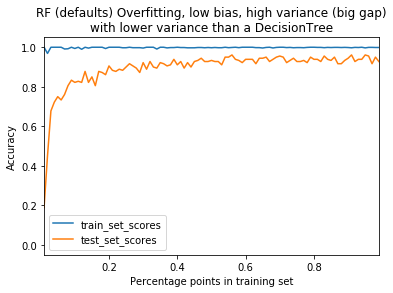

In [16]:
training_set_scores = np.zeros_like(train_set_sizes)
test_set_scores = np.zeros_like(train_set_sizes)

clf = RandomForestClassifier()

for training_set_idx, train_set_size in enumerate(train_set_sizes):
    X_train_subset, _, y_train_subset, _ = train_test_split(X_train, y_train, test_size=1-train_set_size, random_state=RANDOM_STATE)

    clf.fit(X_train_subset, y_train_subset)
    train_score = clf.score(X_train_subset, y_train_subset)
    training_set_scores[training_set_idx] = train_score
    
    test_score = clf.score(X_test, y_test)
    test_set_scores[training_set_idx] = test_score

df_scores = pd.DataFrame({'idx': train_set_sizes, 'test_set_scores': test_set_scores, 'train_set_scores': training_set_scores})
df_scores = df_scores.set_index('idx')
df_scores = df_scores[['train_set_scores', 'test_set_scores']] # reorder columns

df_scores.plot()
plt.ylim((-0.05, 1.05))
plt.ylabel("Accuracy")
plt.xlabel("Percentage points in training set")
plt.title("RF (defaults) Overfitting, low bias, high variance (big gap)\nwith lower variance than a DecisionTree");

## Hyperparameter optimisation

Use `GridSearchCV` to search a 2D grid of parameters (`n_estimators` and `max_depth`), visualise the scores obtained for the Cartesian Product of all combinations in a 2D plot. We use one of the best results to fit a final `RandomForestClassifier` using better hyperparameters and visualise the final result. 

In [17]:
from operator import itemgetter

def report(grid_scores, n_top=3):
    # attrib: http://scikit-learn.org/stable/auto_examples/model_selection/randomized_search.html
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")

In [18]:
# TODO Ian - this code is clunky, think on a cleaner implementation!

def convert_grid_search_into_df(grid_search, param_grid):
    """Convert 2D grid_search results into 2D DataFrame"""
    keys = list(param_grid.keys())
    assert len(keys) == 2 # we can only plot 2D
    x_key = keys[0]
    y_key = keys[1]
    x_steps = param_grid[x_key]
    y_steps = param_grid[y_key]
    scores_arr = np.zeros((x_steps.shape[0], y_steps.shape[0]))
    for grid_result in grid_search.grid_scores_:
        params = grid_result.parameters
        x_value = params[x_key]
        x_idx = np.where(x_steps==x_value)[0][0]
        y_value = params[y_key]
        y_idx = np.where(y_steps==y_value)[0][0]    
        scores_arr[x_idx, y_idx] = grid_result.mean_validation_score

    df_hyperparameters = pd.DataFrame.from_records(scores_arr.T, columns=[x_steps], index=[y_steps])
    return df_hyperparameters, x_key, y_key

### DecisionTree

We can get to 0.84 by a `max_depth` of 11 but we won't do any better with a single tree.

In [21]:
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

param_grid = {'max_depth': np.arange(1, 56, 5),
              'min_samples_leaf': np.arange(1, 2, 1)} # this is a dummy parameter to make a 2D grid

clf = DecisionTreeClassifier()
grid_search = GridSearchCV(clf, param_grid)
grid_search.fit(X_train, y_train)
report(grid_search.grid_scores_)

Model with rank: 1
Mean validation score: 0.852 (std: 0.006)
Parameters: {'max_depth': 31, 'min_samples_leaf': 1}

Model with rank: 2
Mean validation score: 0.851 (std: 0.006)
Parameters: {'max_depth': 16, 'min_samples_leaf': 1}

Model with rank: 3
Mean validation score: 0.844 (std: 0.009)
Parameters: {'max_depth': 21, 'min_samples_leaf': 1}



/home/ian/anaconda3/envs/data_science_delivered/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


/home/ian/anaconda3/envs/data_science_delivered/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


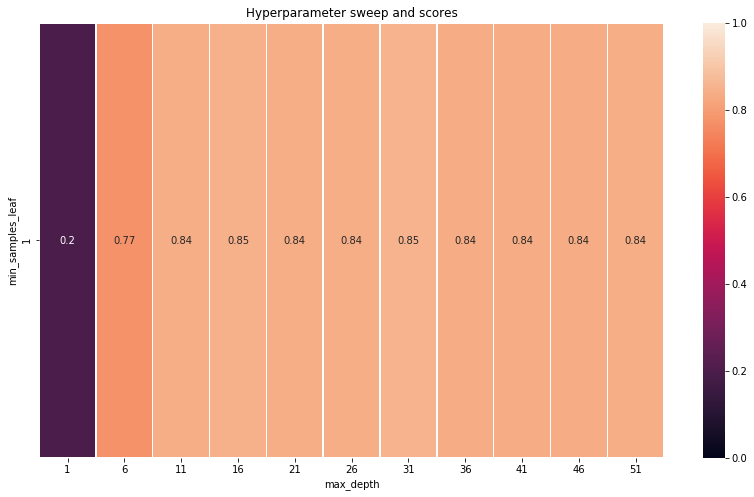

In [22]:
df_hyperparameters, x_key, y_key = convert_grid_search_into_df(grid_search, param_grid)

f, ax=plt.subplots(1, 1, figsize=(14,8))
sns.heatmap(df_hyperparameters, annot=True, linewidths=.5, ax=ax, vmin=0, vmax=1.0)
plt.xlabel(x_key)
plt.ylabel(y_key)
plt.title("Hyperparameter sweep and scores");

### RandomForest 

With a quick sweep of `n_estimators` we quickly beat `the DecisionTree`'s score of 0.84 and get to 0.91, this works with less-deep trees in the ensemble. The trick is to combine many trees.

In [23]:
from sklearn.grid_search import GridSearchCV

param_grid = {'n_estimators': np.arange(1, 10, 1),
              'max_depth': np.arange(1, 10, 1)}

clf = RandomForestClassifier()
grid_search = GridSearchCV(clf, param_grid)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([1, 2, 3, 4, 5, 6, 7, 8, 9]), 'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [24]:
report(grid_search.grid_scores_)

Model with rank: 1
Mean validation score: 0.926 (std: 0.012)
Parameters: {'max_depth': 9, 'n_estimators': 9}

Model with rank: 2
Mean validation score: 0.908 (std: 0.013)
Parameters: {'max_depth': 7, 'n_estimators': 9}

Model with rank: 3
Mean validation score: 0.908 (std: 0.005)
Parameters: {'max_depth': 8, 'n_estimators': 8}



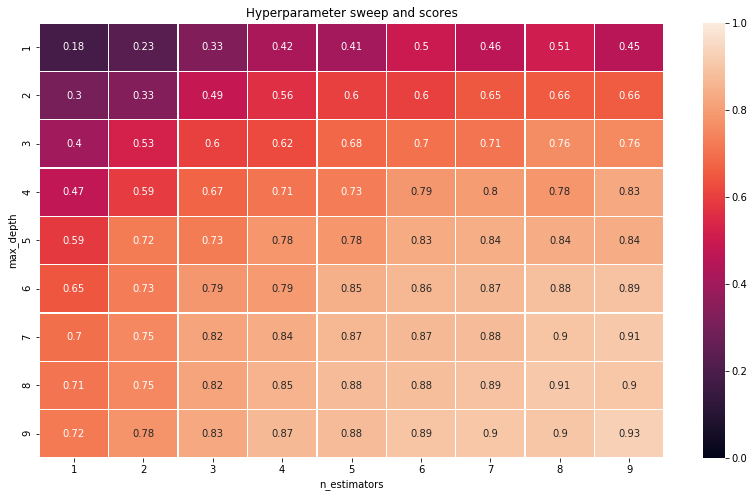

In [25]:
df_hyperparameters, x_key, y_key = convert_grid_search_into_df(grid_search, param_grid)

f, ax=plt.subplots(1, 1, figsize=(14,8))
sns.heatmap(df_hyperparameters, annot=True, linewidths=.5, ax=ax, vmin=0, vmax=1.0)
plt.xlabel(x_key)
plt.ylabel(y_key)
plt.title("Hyperparameter sweep and scores");

#### Search on a larger grid

We can see that increasing the `max_depth` doesn't help, we don't improve the score after a depth of 20 or so decisions (given this feature set and number of examples). By increasing the number of trees we can make impressively high scores even with a `max_depth` of `1`. Our best scores top out at approximately `0.96`.

In [26]:
# scan from 1..100 with log-scaled increments
param_grid = {'n_estimators': np.logspace(0.2, 3, num=10, dtype=np.int_),
              'max_depth': np.logspace(0.2, 1.7, num=10, dtype=np.int_)} 

clf = RandomForestClassifier()
grid_search = GridSearchCV(clf, param_grid)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([   1,    3,    6,   13,   27,   56,  116,  238,  488, 1000]), 'max_depth': array([ 1,  2,  3,  5,  7, 10, 15, 23, 34, 50])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [27]:
report(grid_search.grid_scores_)

Model with rank: 1
Mean validation score: 0.962 (std: 0.003)
Parameters: {'max_depth': 50, 'n_estimators': 488}

Model with rank: 2
Mean validation score: 0.961 (std: 0.004)
Parameters: {'max_depth': 15, 'n_estimators': 1000}

Model with rank: 3
Mean validation score: 0.961 (std: 0.002)
Parameters: {'max_depth': 34, 'n_estimators': 238}



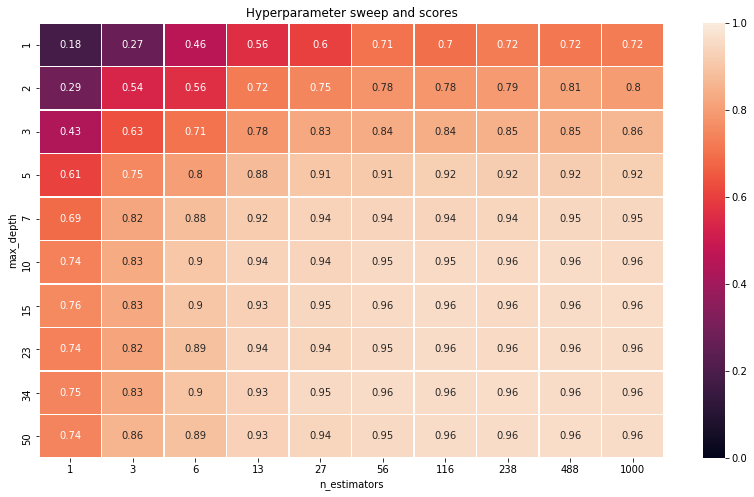

In [28]:
df_hyperparameters, x_key, y_key = convert_grid_search_into_df(grid_search, param_grid)

f, ax=plt.subplots(1, 1, figsize=(14,8))
sns.heatmap(df_hyperparameters, annot=True, linewidths=.5, ax=ax, vmin=0, vmax=1.0)
plt.xlabel(x_key)
plt.ylabel(y_key)
plt.title("Hyperparameter sweep and scores");

### Finish with a strong RandomForest using tuned hyperparameters

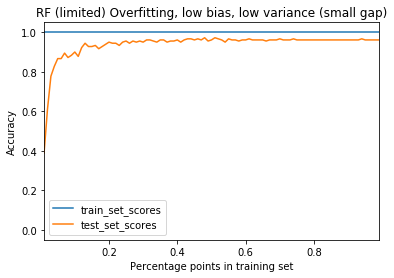

In [29]:
training_set_scores = np.zeros_like(train_set_sizes)
test_set_scores = np.zeros_like(train_set_sizes)

# note the hyperparameters were chosen using the process in the hyperparameter section
# generally you'd pick the highest-scoring configuration that's built in the least expensive
# way (i.e. fewest estimators and least depth) for speed of execution and higher likelihood
# of generalising to unseen future data
clf = RandomForestClassifier(n_estimators=238, max_depth=15)

for training_set_idx, train_set_size in enumerate(train_set_sizes):
    X_train_subset, _, y_train_subset, _ = train_test_split(X_train, y_train, test_size=1-train_set_size, random_state=RANDOM_STATE)

    clf.fit(X_train_subset, y_train_subset)
    train_score = clf.score(X_train_subset, y_train_subset)
    training_set_scores[training_set_idx] = train_score
    
    test_score = clf.score(X_test, y_test)
    test_set_scores[training_set_idx] = test_score

df_scores = pd.DataFrame({'idx': train_set_sizes, 'test_set_scores': test_set_scores, 'train_set_scores': training_set_scores})
df_scores = df_scores.set_index('idx')
df_scores = df_scores[['train_set_scores', 'test_set_scores']] # reorder columns

df_scores.plot()
plt.ylim((-0.05, 1.05))
plt.ylabel("Accuracy")
plt.xlabel("Percentage points in training set")
plt.title("RF (limited) Overfitting, low bias, low variance (small gap)");

# Next steps

* http://scikit-learn.org/stable/auto_examples/ensemble/plot_partial_dependence.html perhaps try a Partial Dependence plot
* record execution time for each param pair in hyperparameter sweep, do a 2nd plot showing time-cost to calculate each version - is it more expensive to build deeper trees or to add more trees?

# Confirm Notebook ran to completion

In [30]:
print("Completed running this Notebook at:", datetime.datetime.now())

Completed running this Notebook at: 2017-10-04 12:03:54.236883
